# Israel Bus Arrival Times
This notebook was created by Yoav Elkayam as part of the Data Science workshop at the Israel Open University, Spring of 2024.

## Purpose and Goal definition

### Purpose

Public transportation is a vital part of urban mobility in Israel, and for soldiers, it serves as the primary means of transportation between bases, home, and other assignments. It's no secret that public transportation in Israel is not the most punctual type, and delays in bus schedules can cause significant inconvenience. These delays not only affect daily commutes but also the coordination of military activities, where punctuality is critical.

As a soldier who relies on public transport daily, I have personally experienced the challenges caused by unpredictable bus delays. This project aims to address these challenges by analyzing bus journey data and identifying patterns that cause delays, such as traffic conditions and peak travel times.

By building a reliable predictive model for bus delays, the project aims to improve the accuracy of bus arrival time estimates. This will not only benefit soldiers but also the general population, helping both transportation agencies and passengers better manage schedules and reduce inefficiencies.

Furthermore, understanding key factors like rush hour peaks, holiday schedules, and different route characteristics will provide insights to improve route planning and optimize bus networks for the benefit of all passengers.

### Goal

The primary goal of this project is to develop a predictive model that estimates bus arrival times, helping to reduce the uncertainty caused by delays in the public transportation system. Specifically, the project aims to:

1. Predict Bus Delays: Build a machine learning model capable of predicting delays for specific bus routes and stops based on historical data. This will help transportation agencies and passengers, including soldiers, better plan for travel, reducing frustration and improving overall efficiency.

2. Analyze Delay Patterns: Through Exploratory Data Analysis (EDA), identify important patterns and trends in the data, such as how delays vary during different times of the day (rush hours), on weekends versus weekdays, or during public holidays. This will provide insights into the factors that most influence delays.

3. Feature Engineering for Holidays and Peak Times: Introduce additional features, such as dummy variables for special days (e.g., holidays) and rush hour periods, to improve model accuracy. By capturing the impact of these factors, the model will better generalize to different days and times.

4. Model Evaluation and Comparison: Train and compare different machine learning models (e.g., Linear Regression, Random Forest, Gradient Boosting) to identify which model performs best in predicting bus delays. The evaluation will be based on key metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

5. Interpreting Model Predictions: Use explainability tools (such as SHAP) to understand how the model makes predictions. This will help identify the most important features driving the model's predictions, offering deeper insights into the main causes of bus delays.

By achieving these goals, the project will not only provide accurate predictions of bus arrival times but also contribute to understanding the key factors that cause delays. This can ultimately assist public transportation agencies in improving schedules and managing resources more effectively.



## Data Overview and Collection Process

The dataset we are investigating originates from the Israeli Ministry of Transportation (MOT), with data collected by "The Public Knowledge Workshop (Hasadna)." Hasadna is a civic technology organization that collects and processes data from various public entities, including transportation data, with the goal of increasing transparency and promoting public engagement.

The dataset is made available through their Open-Bus Stride API, which provides detailed information on bus movements across Israel. This enriched dataset merges two key types of information:
1. **Planned Schedule Data (GTFS)**: This dataset includes the planned schedules of bus routes, stops, and estimated arrival times, as specified by the transportation companies. It provides the theoretical framework of how buses are expected to run.
2. **Real-Time Bus Data**: This dataset captures the actual movement of buses in real time, based on GPS coordinates and other sensors installed on the buses. It includes information on when buses arrive at or pass each stop along their routes.

### Data Enrichment Process
The enrichment process that combines these two datasets is critical for providing a complete picture of how buses operate in practice. This process links the planned schedules with real-time data, allowing us to compare how closely buses follow their schedules. For example, we can observe when and where delays occur by comparing the expected arrival time from GTFS with the actual arrival time from the real-time data.

The enriched dataset offers additional insights by including calculated fields such as the nearest bus stop relative to the bus’s real-time location. Although this information is already part of the enriched data, we recalculate certain aspects—such as determining the closest bus stop—within this notebook to improve accuracy in the analysis.

### Purpose of Data Decomposition
In the first part of this notebook, we will break down the enriched data into its two components: the scheduled bus data and the real-time data. By doing so, we can reconstruct the bus routes, mapping out the points that represent each stop along the journey. This process will help us calculate the actual arrival times at each stop, which becomes the target variable for the predictive model we aim to build.

The decomposition of the data is necessary because the data is not provided in a format that allows direct use for this type of analysis. Furthermore, by recalculating specific features—such as determining the nearest bus stop location—we enhance the precision of the dataset, which is critical for developing accurate models.

### Time Frame and Data Selection
For this analysis, we will focus on data from **January 2023 to October 2023**. This period was chosen to avoid complications caused by external disruptions, such as the GPS signal interferences that occurred during the Israel–Hamas war. These disruptions affected the accuracy of location data, and by excluding periods of GPS disruption, we can ensure that our analysis is based on reliable data.

By focusing on this timeframe, we aim to capture a representative sample of bus operations under normal conditions, including peak travel times, holidays, and regular weekdays. This will allow us to model and predict bus delays under typical operational circumstances.


## Key terms Dictionary

| Term          | Definition                                                   |
|---------------|--------------------------------------------------------------|
| SIRI |  Service Interface for Real Time Information. Columns that start with "siri_" has data from real time bus locations pings.|
| GTFS | General Transit Feed Specification. Columns that start with "gtfs_" has data from planned bus schedule |
| Journey | A trip a bus take from its starting station to its last station on a specific route. When a bus send its location information, its related to one journey. Each journey has many location records in the data. |
| Another Term  | Another definition goes here.                                |

# Import Dependencies


In [9]:
# Importing necessary libraries
import os
import glob
import time
from datetime import timedelta, date
import re
import importlib


import uuid
import pyarrow.parquet as pq

import pandas as pd
import numpy as np
from geopy.distance import geodesic
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from numba import jit
import concurrent.futures
from sqlalchemy import create_engine



from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


import data_processing



# The stride client library, used to make the calls to the stride api
# import stride

In [14]:
importlib.reload(data_processing)

<module 'data_processing' from '/Users/yoavelkayam/Documents/OpenU/סדנה במדעי הנתונים/data-science-project/data_processing.py'>

### Defining Data location based on current workspace

In [2]:
DATA_FOLDER = './2023_siri_data'

In [ ]:
DATA_FOLDER = './drive/MyDrive/2023_siri_data'

In [28]:
DATA_FOLDER = 'G:\\My Drive\\2023_siri_data'

### Defining Time Boundaries For processing

In [4]:
START_DATE = "2023-01-01"
END_DATE = "2023-03-23"

# Data Collection

Our data is sourced from the Open-Bus Stride ETL packages. These packages provide data in hourly intervals. The data includes information about bus locations, the nearest stop to each bus location, and correlations to the GTFS ride. This includes the date and time of scheduled arrival times, among other details.


## Downloading Data
Here we download all data from the API

In [ ]:
data_processing.download_files(2023, DATA_FOLDER)

## Keeping the data intact

We might have a missing file in the data folder.
This function checks for missing files based on the compressed files folder


In [ ]:
data_processing.extract_missing_csv(DATA_FOLDER)

## Data Processing and Segmentation

This cell is designed to efficiently manage and process large datasets by breaking them down into more manageable chunks, optimizing memory usage, and enhancing data accessibility. The process involves several key steps:

1. **Data Segmentation**: The script segments large CSV files into smaller Parquet files, each containing up to 10 million rows. This segmentation facilitates easier handling of large datasets, as Parquet files are more efficient in terms of storage and speed when accessing subsets of data.

2. **Type Conversion and Cleanup**: It converts data types for specific columns to ensure consistency and optimizes memory usage. For example, it converts certain columns to string, integer, and floating-point types as needed. Additionally, it processes date columns to ensure they are in the correct datetime format.

3. **Column Removal**: To streamline the dataset, the script removes columns that are not immediately necessary for analysis. This step reduces file size and simplifies the dataset, making it easier to work with. The columns to be removed are specified in the [`columns_to_drop`](command:_github.copilot.openSymbolFromReferences?%5B%7B%22%24mid%22%3A1%2C%22fsPath%22%3A%22%2FUsers%2Fyoavelkayam%2FDocuments%2FOpenU%2F%D7%A1%D7%93%D7%A0%D7%94%20%D7%91%D7%9E%D7%93%D7%A2%D7%99%20%D7%94%D7%A0%D7%AA%D7%95%D7%A0%D7%99%D7%9D%2Fdata-science-project%2Fproject.ipynb%22%2C%22path%22%3A%22%2FUsers%2Fyoavelkayam%2FDocuments%2FOpenU%2F%D7%A1%D7%93%D7%A0%D7%94%20%D7%91%D7%9E%D7%93%D7%A2%D7%99%20%D7%94%D7%A0%D7%AA%D7%95%D7%A0%D7%99%D7%9D%2Fdata-science-project%2Fproject.ipynb%22%2C%22scheme%22%3A%22vscode-notebook-cell%22%2C%22fragment%22%3A%22X20sZmlsZQ%3D%3D%22%7D%2C%7B%22line%22%3A67%2C%22character%22%3A4%7D%5D "/Users/yoavelkayam/Documents/OpenU/סדנה במדעי הנתונים/data-science-project/project.ipynb") list.

4. **File Management**: The script includes functionality to manage files efficiently. It removes the original CSV files after processing them into Parquet format to free up storage space. It also handles the continuation of data processing from where it left off, by identifying the last processed file and its position, thus avoiding reprocessing of data.

5. **Data Deduplication**: Before appending new data to the dataset, it removes duplicate entries to ensure the uniqueness of records.

6. **Dynamic File Naming**: The output Parquet files are named dynamically based on their content, indicating the range of data they contain. This naming convention makes it easier to identify and access specific segments of data.

7. **Efficient Data Concatenation**: The script concatenates new data to an existing DataFrame until the specified row limit is reached. Once the limit is reached, the data is saved to a Parquet file, and the process continues with the remaining data.

This approach not only optimizes the processing of large datasets by reducing memory overhead but also organizes the data into a more accessible and efficient format, facilitating faster data retrieval and analysis.

In [15]:
data_processing.process_files(DATA_FOLDER)

Folder size before processing: 62948374055 bytes
Folder size after processing: 62948374055 bytes


# Data Examination

In this phase, we will focus on analyzing a single bus line, specifically line 68, which operates from Kiryat Ono terminal to Tel-Aviv central station. Our analysis will be limited to the first month of 2023.

Our primary goal is to identify instances of delays and subsequently investigate potential causes for these delays.

To facilitate this, we will prepare a DataFrame that consolidates all relevant data pertaining to this bus line.


In [8]:
def create_filtered_df(parquet_dir, line_refs, limit=0, offset=0):
    parquet_files = glob.glob(f'{parquet_dir}/output_*.parquet')

    parquet_files.sort(key=data_processing.extract_number)
    
    if limit > 0:
        parquet_files = parquet_files[offset:offset+limit]
    else:
        parquet_files = parquet_files[offset:]

    df = pd.DataFrame()
    
    counter = 0

    for file in parquet_files:
        # Read the Parquet file
        temp_df = pd.read_parquet(file, filters=[('siri_line_ref', 'in', line_refs)])
        temp = temp_df.astype({'gtfs_stop_lat': float, 'gtfs_stop_lon': float, 'lat': float, 'lon': float})
        df = pd.concat([df, temp_df])
        counter += 1

        if counter % 20 == 0:
            print(f'Processed {counter} files. Current file: {os.path.basename(file)}')

    return df

In [31]:
df = create_filtered_df(f'{DATA_FOLDER}/concatenated_data_parquet', ['987'])

In [35]:
df.head()

,id,siri_journey_ref,siri_vehicle_ref,siri_stop_code,siri_stop_order,siri_operator_ref,siri_line_ref,gtfs_journey_ref,gtfs_start_time,gtfs_end_time,...,estimated_arrival_time__minute,estimated_arrival_time__second,estimated_arrival_time__day_of_month,estimated_arrival_time__month,scheduled_arrival_time__day_of_week,scheduled_arrival_time__hour,scheduled_arrival_time__minute,scheduled_arrival_time__second,scheduled_arrival_time__day_of_month,scheduled_arrival_time__month
0,1454887456,2023-01-02-215531,7259652,20160,2,18,987,215445_010123,2023-01-02 03:30:00+00:00,2023-01-02 04:21:45+00:00,...,30,25,2,1,0.0,3.0,33.0,18.0,2.0,1.0
1,1454890568,2023-01-02-215531,7259652,23017,6,18,987,215445_010123,2023-01-02 03:30:00+00:00,2023-01-02 04:21:45+00:00,...,33,10,2,1,0.0,3.0,37.0,59.0,2.0,1.0
2,1454893698,2023-01-02-215531,7259652,21669,8,18,987,215445_010123,2023-01-02 03:30:00+00:00,2023-01-02 04:21:45+00:00,...,35,59,2,1,0.0,3.0,41.0,53.0,2.0,1.0
3,1454897086,2023-01-02-215531,7259652,21764,9,18,987,215445_010123,2023-01-02 03:30:00+00:00,2023-01-02 04:21:45+00:00,...,36,32,2,1,0.0,3.0,42.0,59.0,2.0,1.0
4,1454898801,2023-01-02-215531,7259652,28665,11,18,987,215445_010123,2023-01-02 03:30:00+00:00,2023-01-02 04:21:45+00:00,...,38,5,2,1,0.0,3.0,44.0,6.0,2.0,1.0


## Sorting and Formatting Data

In this step, we sort the dataframe `df` by 'siri_journey_ref' and 'recorded_at_time'. 

We then create two new dataframes:

- `df_bus_journey_stops`: This dataframe is created by selecting specific columns from `df_sorted` and dropping duplicates. It contains information about the bus journey stops.

- `df_locations`: This dataframe is created by excluding columns that start with 'gtfs' from `df_sorted`. It contains information about the bus locations from siri.


In [9]:
def process_dataframe(df):
    df_sorted = df.sort_values(['siri_journey_ref', 'recorded_at_time'])
    
    bus_journey_cols = ['id','siri_journey_ref', 'siri_vehicle_ref', 'siri_stop_code', 'siri_stop_order', 'siri_operator_ref', 'siri_line_ref', 'gtfs_journey_ref', 'gtfs_start_time', 'gtfs_end_time', 'gtfs_stop_code', 'gtfs_stop_lat', 'gtfs_stop_lon', 'gtfs_stop_city', 'gtfs_arrival_time', 'gtfs_stop_sequence', 'gtfs_route_short_name', 'gtfs_route_direction', 'gtfs_route_mkt']
    df_bus_journey_stops = df_sorted[bus_journey_cols].drop_duplicates()

    # Remove rows where 'gtfs_stop_lat' or 'gtfs_stop_lon' is NaN
    df_bus_journey_stops = df_bus_journey_stops.dropna(subset=['gtfs_stop_lat', 'gtfs_stop_lon'])

    location_cols = [col for col in df_sorted.columns if not col.startswith('gtfs')]
    df_locations = df_sorted[location_cols]

     # Remove journeys where all locations have the same lat and lon
    journey_counts = df_locations.groupby('siri_journey_ref')[['lat', 'lon']].nunique()
    journeys_to_keep = journey_counts[(journey_counts['lat'] > 2) | (journey_counts['lon'] > 2)].index
    df_locations = df_locations[df_locations['siri_journey_ref'].isin(journeys_to_keep)]
    df_bus_journey_stops = df_bus_journey_stops[df_bus_journey_stops['siri_journey_ref'].isin(journeys_to_keep)]
    df_bus_journey_stops.drop_duplicates(subset=['gtfs_stop_code', 'gtfs_stop_lat', 'gtfs_stop_lon', 'siri_journey_ref'], inplace=True)


    return df_bus_journey_stops, df_locations

In [86]:
df_bus_journey_stops, df_locations = process_dataframe(df)

## Calculating Distance and Speed

In this step, we define a function `calculate_distance_and_speed` to calculate the distance and speed for each journey.

- The `haversine` function calculates the distance between two points on the Earth's surface given their latitudes and longitudes.
- It then calculates the time difference between consecutive locations and uses this to calculate the speed.
- Any `NaN` values in the 'speed', 'distance', and 'time_diff' columns are replaced with 0.

Finally, we apply this function to our DataFrame `df_locations` using the `groupby` and `apply` methods, and reset the index.


In [10]:
# Pre-calculate constants outside the function
earth_radius = 6367 * 2 * np.pi

@jit(nopython=True)
def haversine(lat1, lon1, lat2, lon2):

    # Convert coordinates to radians (vectorized)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula (vectorized operations)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    return earth_radius * c

def calculate_distance_and_speed(group):
    
    lats = group['lat'].values
    lons = group['lon'].values

    # Vectorized haversine calculation
    distances = haversine(lats[:-1], lons[:-1], lats[1:], lons[1:])

    # Add distance and time difference columns
    group['distance'] = np.append(distances, np.nan)
    group['time_diff'] = (group['recorded_at_time'].shift(-1) - group['recorded_at_time']).dt.total_seconds() / 3600

    # Calculate speed
    group['speed'] = group['distance'] / np.maximum(group['time_diff'], 1e-9)

    # Replace NaN values with 0
    group['speed'] = np.nan_to_num(group['speed'])
    group['distance'] = np.nan_to_num(group['distance'])
    group['time_diff'] = np.nan_to_num(group['time_diff'])

    return group

def process_locations(df_locations):
    df_locations = df_locations.groupby('siri_journey_ref').apply(calculate_distance_and_speed)
    df_locations.reset_index(drop=True, inplace=True)
    return df_locations


In [80]:
df_locations = process_locations(df_locations)

## Calculating Arrival Times

In this step, we define several functions to calculate the estimated arrival times at each bus stop for each journey.

- The `calculate_bearing` function calculates the bearing between two points on the Earth's surface.
- The `calculate_arrival_times` function uses the above  function and the haversine function to estimate the arrival times at each bus stop for each journey. It takes into account the speed of the bus, the distance to the next stop, and the direction of the bus.

An important part of the `calculate_arrival_times` function is the calculation of the 'moving_towards_stop' field. This field is a boolean that indicates whether the bus is moving towards or away from the stop. It is calculated by comparing the bearing of the bus to the bearing of the line from the bus to the stop. If the bus's bearing is within a certain range of the bearing to the stop, then the bus is considered to be moving towards the stop. This calculation is important because it allows us to distinguish between a bus that is approaching a stop and a bus that has already passed a stop.

The 'distance_from_stop' field is the distance from the closest bus location to the stop. It is calculated using the `haversine` function.

The 'estimated_arrival_time' field is the estimated time that the bus will arrive at the stop. It is calculated by adding the estimated time to the stop (which is the distance to the stop divided by the speed of the bus) to the time that the closest location was recorded. If the bus is moving away from the stop, the estimated time to the stop is subtracted from the recorded time instead.

Finally, we call the `calculate_arrival_times` function to calculate the estimated arrival times for our data.


In [11]:
@jit(nopython=True)
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Calculate the difference in longitudes
    dlon = lon2 - lon1

    # Calculate the bearing
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    bearing = np.degrees(np.arctan2(x, y))

    # Normalize the bearing to be between 0 and 360
    return (bearing + 360) % 360

def calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=15):
    results = []

    df_locations['speed'] = df_locations['speed'].replace(0, np.nan)

    grouped_locations = df_locations.groupby('siri_journey_ref')

    for journey, journey_locations in grouped_locations:
        journey_stops = df_bus_journey_stops[df_bus_journey_stops['siri_journey_ref'] == journey]

        # Skip the journey if it only has 2 or fewer stops
        if len(journey_stops) <= 2:
            continue
        
        journey_locations = journey_locations.sort_values('recorded_at_time')

        # Interpolate to fill NaN values with the nearest non-NaN values
        journey_locations['speed'] = journey_locations['speed'].interpolate(method='nearest', limit_direction='both')

        # Calculate the mean speed excluding the start and end points
        mean_speed = journey_locations['speed'][1:-1].mean()

        # Fill remaining NaN values at the start and end of the series with the mean speed
        journey_locations['speed'] = journey_locations['speed'].fillna(mean_speed)

        latitudes = journey_locations['lat'].values
        longitudes = journey_locations['lon'].values

        journey_tree = KDTree(list(zip(latitudes, longitudes)), leafsize=4)

        for i, stop in journey_stops.iterrows():
            _, closest_location_idx = journey_tree.query((stop['gtfs_stop_lat'], stop['gtfs_stop_lon']))
            closest_location = journey_locations.iloc[closest_location_idx]

            bearing = calculate_bearing(closest_location['lat'], closest_location['lon'],
                                         stop['gtfs_stop_lat'], stop['gtfs_stop_lon'])

            distance_to_stop = haversine(closest_location['lat'], closest_location['lon'],
                                          stop['gtfs_stop_lat'], stop['gtfs_stop_lon'])

            moving_towards_stop = abs(closest_location['bearing'] - bearing) <= bearing_threshold

            estimated_time_to_stop = (distance_to_stop / closest_location['speed']) * 3600

            # if not moving_towards_stop:
            #     estimated_arrival_time = closest_location['recorded_at_time'] - pd.Timedelta(seconds=estimated_time_to_stop)
            # else:
            #     estimated_arrival_time = closest_location['recorded_at_time'] + pd.Timedelta(seconds=estimated_time_to_stop)

            try:
                if not moving_towards_stop:
                    estimated_arrival_time = closest_location['recorded_at_time'] - pd.Timedelta(seconds=estimated_time_to_stop)
                else:
                    estimated_arrival_time = closest_location['recorded_at_time'] + pd.Timedelta(seconds=estimated_time_to_stop)
            except Exception as e:
                print("An error occurred:", e)
                print("Current values:")
                print(f"closest_location: {closest_location}")
                print(f"stop: {stop}")
            
            results.append({
                'siri_journey_ref': journey,
                'gtfs_stop_code': stop['gtfs_stop_code'],
                'closest_location': closest_location['id'],
                'closest_location_lat': closest_location['lat'],
                'closest_location_lon': closest_location['lon'],
                'closet_location_speed': closest_location['speed'],
                'closest_location_bearing': closest_location['bearing'],
                'recorded_at_time': closest_location['recorded_at_time'],
                'distance_from_stop': distance_to_stop,
                'scheduled_arrival_time': stop['gtfs_arrival_time'],
                'estimated_arrival_time': estimated_arrival_time,
                'moving_towards_stop': moving_towards_stop,
                'arrival_time_diff': estimated_arrival_time - stop['gtfs_arrival_time']
            })

    df_results = pd.DataFrame(results)
    df_results = pd.merge(df_bus_journey_stops, df_results, on=['siri_journey_ref', 'gtfs_stop_code'])
    df_results.drop_duplicates(inplace=True)  # Deduplicate results


    return df_results

In [81]:
results = calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=110)

### Visualizing Bus Locations and Stops for a Specific Journey

In this cell, we are creating a map to visualize the bus locations and stops for a specific journey. This map is centered at the mean latitude and longitude of the journey's locations.

Each bus location is marked with a blue icon, and each stop location is marked with a red icon. If the bus is moving towards the stop, the corresponding marker's popup will show 'Moving Towards Stop: Yes', otherwise it will show 'Moving Towards Stop: No'.

We also draw a blue line connecting all the bus locations and a red line connecting all the stop locations. This visual representation helps us to better understand the 'moving_towards_stop' field that was calculated earlier.

By visualizing a specific journey, we can manually verify if the 'moving_towards_stop' calculation is correct.


In [12]:
def plot_journey(siri_journey_ref, results):
    # Filter the results for the specified journey
    journey_results = results[results['siri_journey_ref'] == siri_journey_ref]

    # Create a map centered at the mean latitude and longitude of the journey's locations
    m = folium.Map(location=[journey_results['closest_location_lat'].mean(), journey_results['closest_location_lon'].mean()], zoom_start=13)

    # Add a marker for each bus location
    for _, row in journey_results.iterrows():
        # Determine whether the bus has already left the stop
        moving_towards_stop = 'Yes' if row['moving_towards_stop'] else 'No'
        
        # Add a marker with a popup showing whether the bus has left the stop
        folium.Marker([row['closest_location_lat'], row['closest_location_lon']], 
                      icon=folium.Icon(color="blue"), 
                      popup=f'Moving Towards Stop: {moving_towards_stop}').add_to(m)
        
    # Add a marker for each stop location
    for _, row in journey_results.iterrows():
        folium.Marker([row['gtfs_stop_lat'], row['gtfs_stop_lon']], icon=folium.Icon(color="red")).add_to(m)

    # Add a line for the bus locations
    bus_locations = journey_results[['closest_location_lat', 'closest_location_lon']].values.tolist()
    folium.PolyLine(bus_locations, color="blue").add_to(m)

    # Add a line for the stop locations
    stop_locations = journey_results[['gtfs_stop_lat', 'gtfs_stop_lon']].values.tolist()
    folium.PolyLine(stop_locations, color="red").add_to(m)

    # Display the map
    return m

In [37]:
plot_journey('2023-01-02-215531', results)

## Bus Arrival Time Analysis

In this cell, we're performing several key steps to analyze bus arrival times:

1. **Calculate Arrival Time Difference**: We first calculate the difference between the estimated arrival time and the scheduled arrival time for each bus. This is done by subtracting the `scheduled_arrival_time` from the `estimated_arrival_time`. The result is stored in a new column in our DataFrame, `results`, named `arrival_time_diff`.

2. **Define Bus Classification Function**: We then define a function, `classify_bus`, that takes in the arrival time difference and a threshold (in minutes) as parameters. This function classifies the bus status into one of four categories:

   - 'Missing': If the arrival time difference is null.
   - 'Late': If the bus arrived later than the scheduled time by more than the threshold.
   - 'Early': If the bus arrived earlier than the scheduled time by more than the threshold.
   - 'On Time': If the bus arrived within the threshold window.

3. **Apply Classification Function**: We set the threshold to 3 minutes and apply the `classify_bus` function to the `arrival_time_diff` column of our DataFrame. The resulting bus status for each row is stored in a new column, `bus_status`.

This preprocessing is key step as it allows us to categorize bus arrival times and understand the distribution of 'Late', 'Early', 'On Time', and 'Missing' statuses across different bus journeys. This categorized data can then be used for further analysis, such as identifying patterns or trends in bus arrival times, or investigating the factors that might influence a bus's punctuality.


In [13]:
def classify_bus(arrival_time_diff, threshold):
    if pd.isnull(arrival_time_diff):
        return 'Missing'
    elif arrival_time_diff > pd.Timedelta(minutes=threshold):
        return 'Late'
    elif arrival_time_diff < -pd.Timedelta(minutes=threshold):
        return 'Early'
    else:
        return 'On Time'

def classify_buses(results, threshold = 3):
    results['bus_status'] = results['arrival_time_diff'].apply(lambda x: classify_bus(x, threshold))
    return  results

In [83]:
results = classify_buses(results)

## Analyzing Late Bus Stops

This cell will do the following:

1. **Filter the DataFrame**: The `results` DataFrame is filtered to only include rows where the `bus_status` is 'Late'. This filtered DataFrame, `late_buses`, includes all instances where a bus was late to a stop, regardless of whether it's the same bus or the same journey.

2. **Analyze the 'recorded_at_time' column**: The `recorded_at_time` column of the `late_buses` DataFrame is analyzed to understand the distribution of late bus stops throughout the day. This is done by extracting the hour from the `recorded_at_time` and creating a histogram.

3. **Plot Histogram**: A histogram is plotted to visualize the number of late bus stops for each hour of the day. The x-axis represents the hour of the day (24-hour format), and the y-axis represents the number of late bus stops.


In [14]:
def plot_late_buses(results):
    late_buses = results[results['bus_status'] == 'Late']
    late_buses['recorded_at_time'].dt.hour.hist()
    plt.title('Time of Day for Late Buses')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Late Buses')
    plt.show()

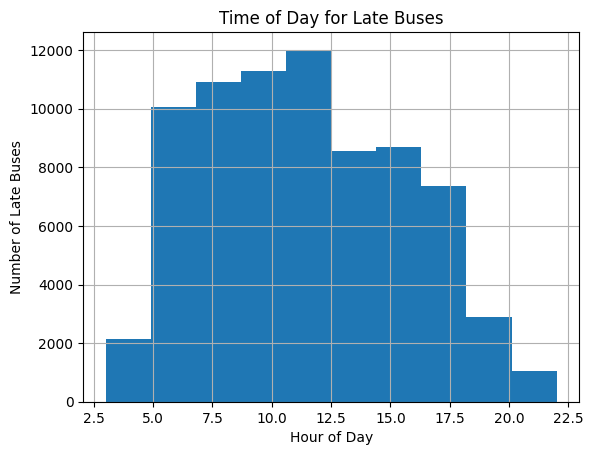

In [38]:
plot_late_buses(results)

# Data Preprocessing and Analysis

The following cell performs several data preprocessing steps on a DataFrame named `results`. Here's a breakdown of what each section does:

1. **Bus Status Conversion**: Converts the 'bus_status' column to numerical values, where 'Late' is represented as 1 and other statuses as 0.

2. **Time Feature Extraction**: Extracts day of the week and hour from 'gtfs_start_time', 'gtfs_end_time', and 'recorded_at_time' columns.


In [15]:
def time_features_extraction(results):
    results['bus_status_num'] = results['bus_status'].apply(lambda x: 1 if x == 'Late' else 0)

    results['gtfs_start_time__day_of_week'] = results['gtfs_start_time'].dt.dayofweek
    results['gtfs_start_time__hour'] = results['gtfs_start_time'].dt.hour

    results['gtfs_end_time__day_of_week'] = results['gtfs_end_time'].dt.dayofweek
    results['gtfs_end_time__hour'] = results['gtfs_end_time'].dt.hour

    results['recorded_at_time__day_of_week'] = results['recorded_at_time'].dt.dayofweek
    results['recorded_at_time__hour'] = results['recorded_at_time'].dt.hour
    results['recorded_at_time__minute'] = results['recorded_at_time'].dt.minute
    results['recorded_at_time__day_of_month'] = results['recorded_at_time'].dt.day
    results['recorded_at_time__month'] = results['recorded_at_time'].dt.month

    results['estimated_arrival_time__day_of_week'] = results['estimated_arrival_time'].dt.dayofweek
    results['estimated_arrival_time__hour'] = results['estimated_arrival_time'].dt.hour
    results['estimated_arrival_time__minute'] = results['estimated_arrival_time'].dt.minute
    results['estimated_arrival_time__second'] = results['estimated_arrival_time'].dt.second
    results['estimated_arrival_time__day_of_month'] = results['estimated_arrival_time'].dt.day
    results['estimated_arrival_time__month'] = results['estimated_arrival_time'].dt.month
    
    results['scheduled_arrival_time__day_of_week'] = results['scheduled_arrival_time'].dt.dayofweek
    results['scheduled_arrival_time__hour'] = results['scheduled_arrival_time'].dt.hour
    results['scheduled_arrival_time__minute'] = results['scheduled_arrival_time'].dt.minute
    results['scheduled_arrival_time__second'] = results['scheduled_arrival_time'].dt.second
    results['scheduled_arrival_time__day_of_month'] = results['scheduled_arrival_time'].dt.day
    results['scheduled_arrival_time__month'] = results['scheduled_arrival_time'].dt.month
    
    return results

In [69]:
results = time_features_extraction(results)

### Analyzing Bus Delays By time features
 
 This cell creates pivot tables for 'recorded_at_time', 'gtfs_start_time', and 'gtfs_end_time' with 'bus_status_num' as values. The pivot tables are indexed by day of the week and hour, and missing values are filled with 0.

The pivot tables provide a summary of the average bus status (late or not) for each hour of each day of the week, for the start time, end time, and recorded time. This can be useful for identifying patterns or trends in bus lateness.

In [16]:
def create_pivot_tables(results):
    def create_pivot_table(df, index_cols, value_col):
        pivot_table = df.pivot_table(index=index_cols, values=value_col, aggfunc='mean')
        all_days_of_week = sorted(df[index_cols[0]].unique())
        all_hours = range(24)
        index = pd.MultiIndex.from_product([all_days_of_week, all_hours], names=index_cols)
        pivot_table = pivot_table.reindex(index)
        pivot_table.fillna(0, inplace=True)
        return pivot_table

    recorded_time_pivot = create_pivot_table(results, ['recorded_at_time__day_of_week', 'recorded_at_time__hour'], 'bus_status_num')
    start_time_pivot = create_pivot_table(results, ['gtfs_start_time__day_of_week', 'gtfs_start_time__hour'], 'bus_status_num')
    end_time_pivot = create_pivot_table(results, ['gtfs_end_time__day_of_week', 'gtfs_end_time__hour'], 'bus_status_num')

    return recorded_time_pivot, start_time_pivot, end_time_pivot

In [39]:
recorded_time_pivot, start_time_pivot, end_time_pivot = create_pivot_tables(df)

#### Heatmap Visualization

This cell generates heatmaps for the pivot tables created in the previous step. The heatmaps visualize the average bus status (late or not) for each hour of each day of the week, for the start time, end time, and recorded time.

Three sets of heatmaps are created:

1. **Recorded Time Heatmaps**: These heatmaps use the pivot table indexed by the day of the week and hour of the 'recorded_at_time'. Each heatmap represents a day of the week.

2. **Start Time Heatmaps**: These heatmaps use the pivot table indexed by the day of the week and hour of the 'gtfs_start_time'. Each heatmap represents a day of the week.

3. **End Time Heatmaps**: These heatmaps use the pivot table indexed by the day of the week and hour of the 'gtfs_end_time'. Each heatmap represents a day of the week.

The color gradient in the heatmaps represents the average bus status, with lighter colors indicating a higher likelihood of the bus being late. This visualization can help identify patterns or trends in bus lateness across different times and days.


In [17]:
def plot_heatmaps(pivot_tables, titles):
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    for pivot_table, title in zip(pivot_tables, titles):
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))

        # Remove the extra subplot
        fig.delaxes(axs[1,3])

        for i, day in enumerate(days_of_week):
            sns.heatmap(pivot_table.loc[i], cmap='viridis', ax=axs[i//4, i%4])
            axs[i//4, i%4].set_title(f'Heatmap for {day} - {title}')

        plt.tight_layout()
        plt.show()

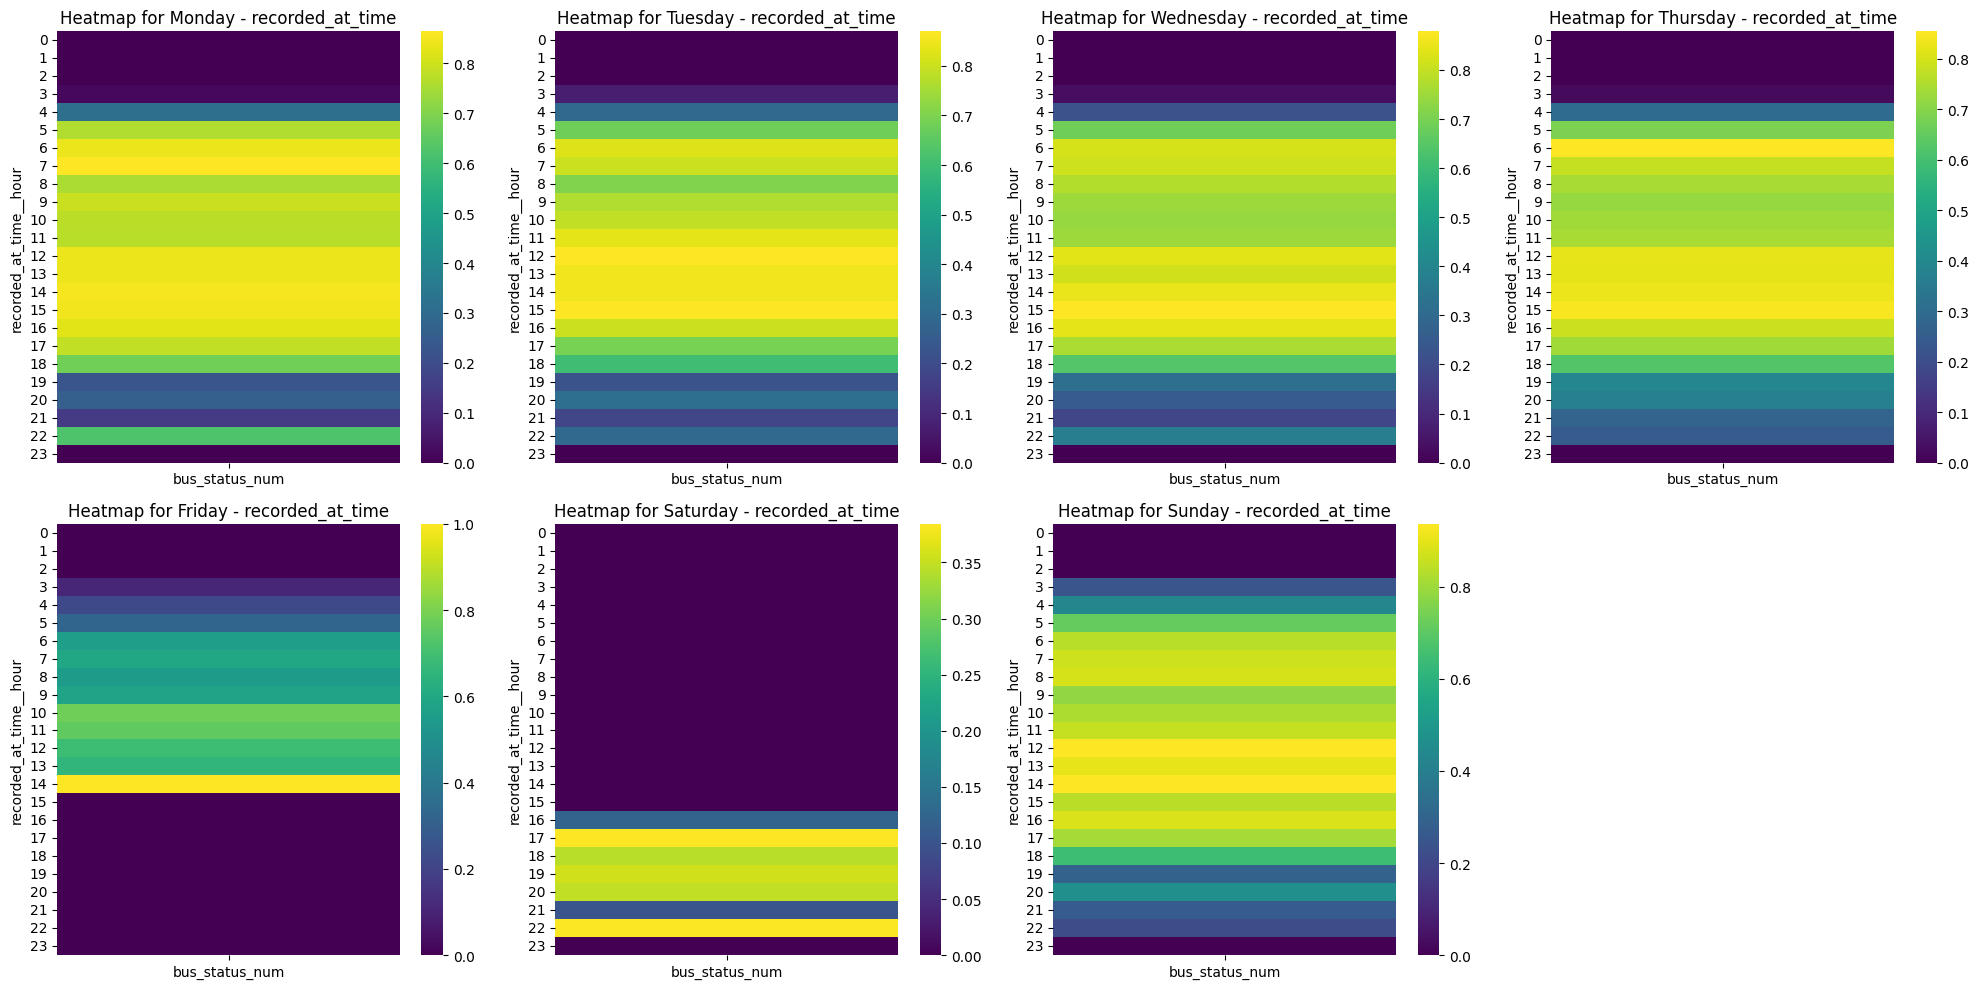

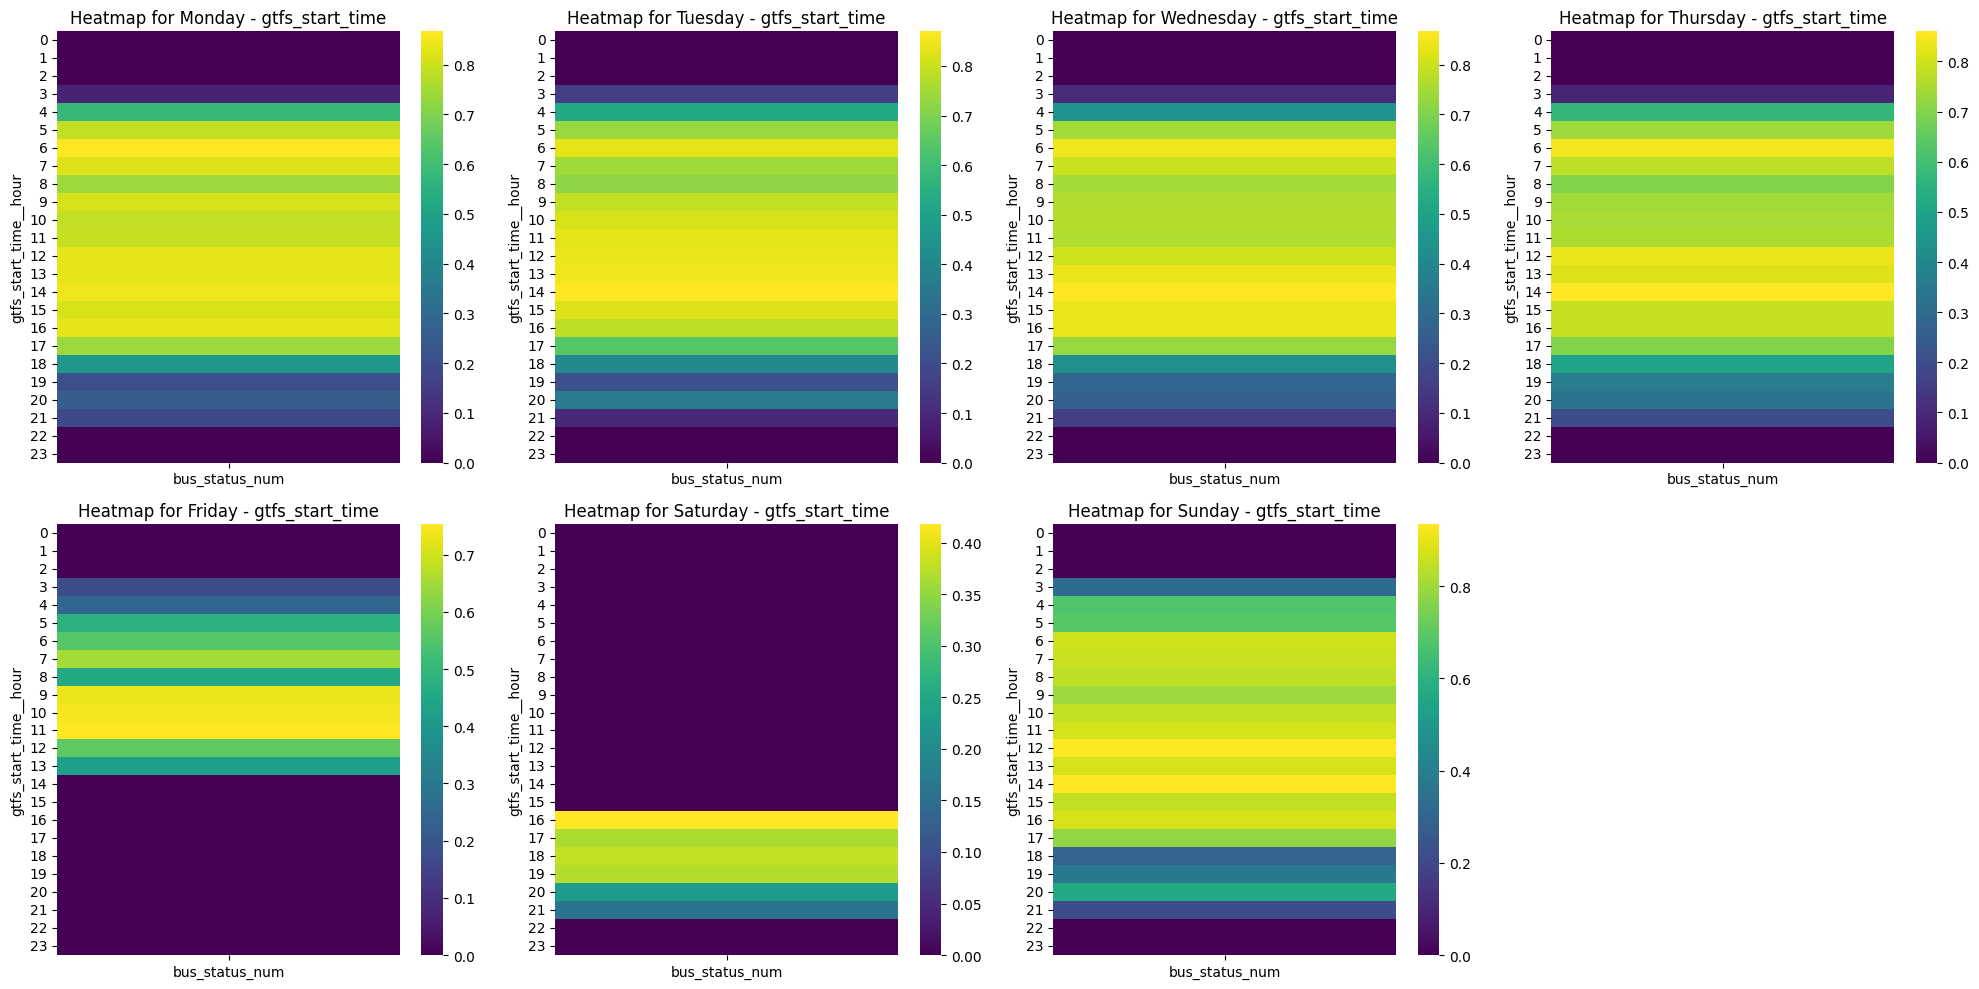

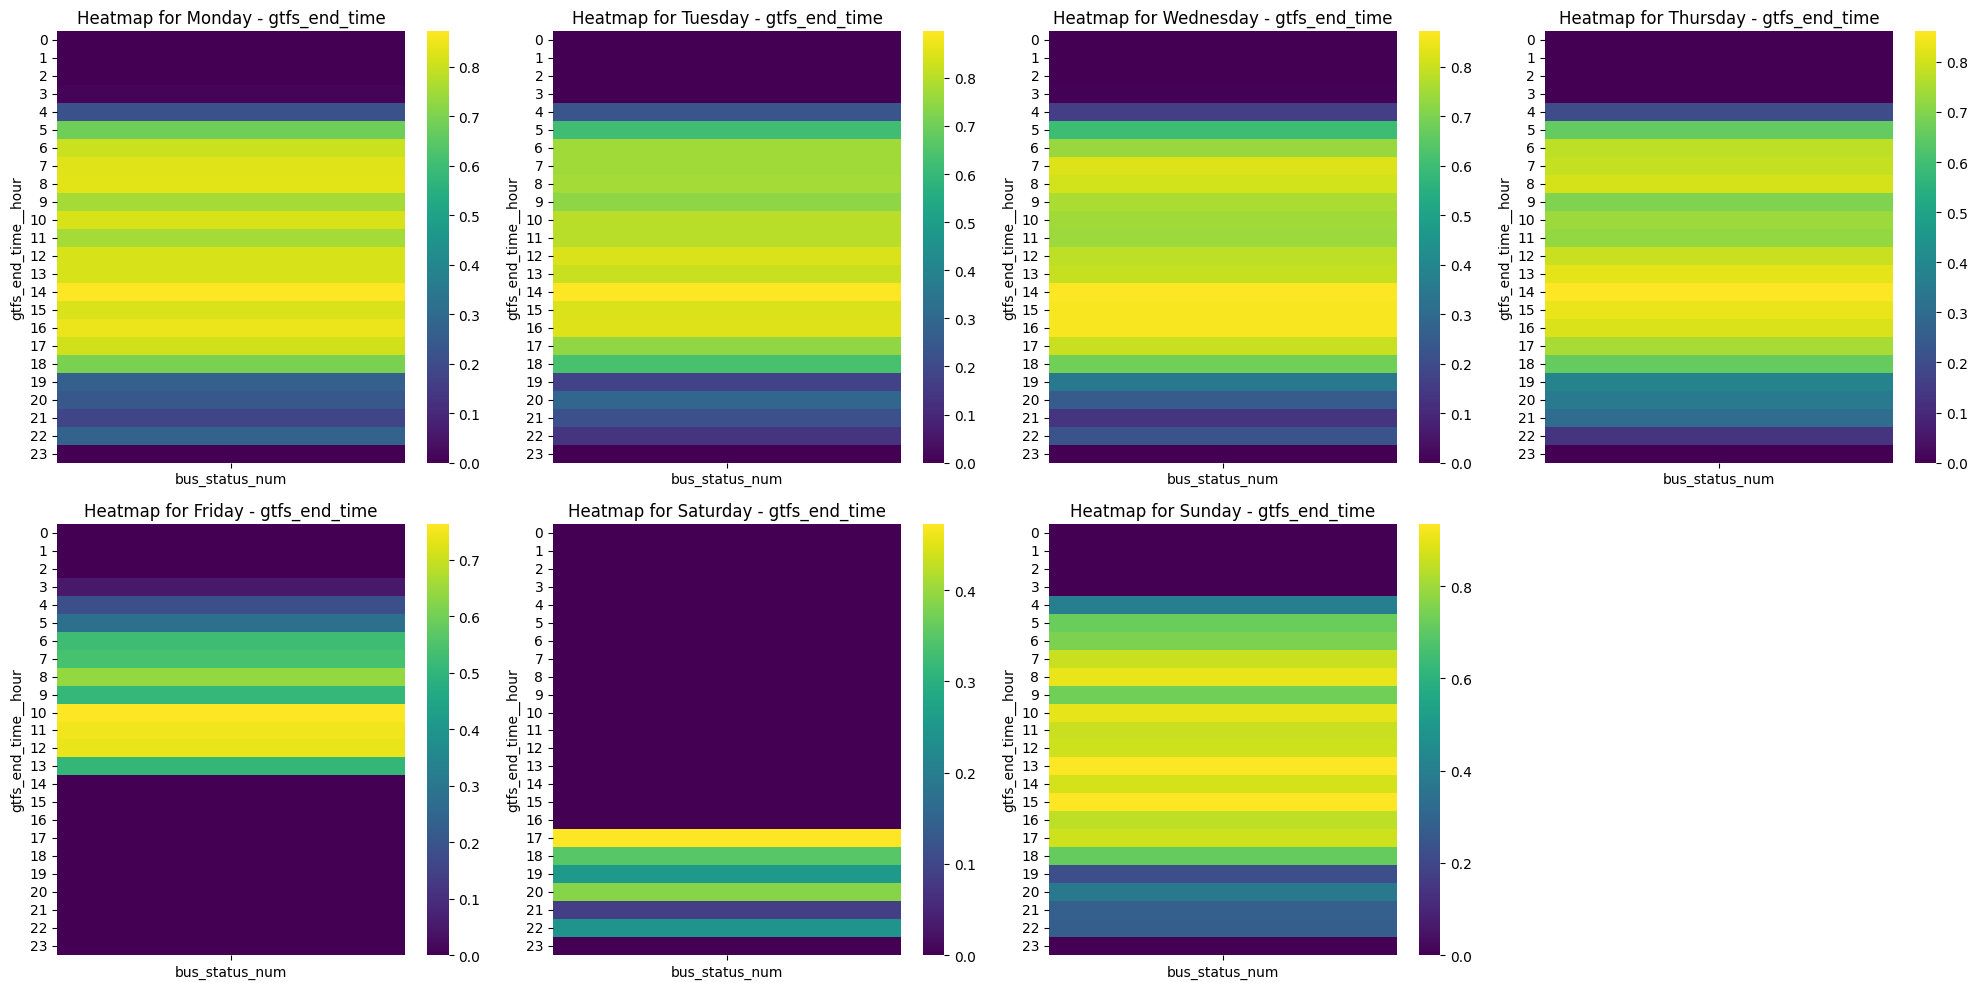

In [40]:
plot_heatmaps([recorded_time_pivot, start_time_pivot, end_time_pivot], ['recorded_at_time', 'gtfs_start_time', 'gtfs_end_time'])

### Analyzing Bus Delays by City

In this analysis, we are investigating the delay of buses across different cities.

The Python code provided creates a pivot table from the `results` DataFrame, using the 'gtfs_stop_city' column as the index and the 'bus_status_num' column as the values. The aggregation function used is 'mean', which gives us the average delay for each city.

A function `reverse_string(s)` is defined and applied to the index of the pivot table to reverse the order of the text.

A heatmap is then created using seaborn's `sns.heatmap()` function, visualizing the average delay of buses in different cities. The color intensity in the heatmap represents the magnitude of the delay.

By examining this heatmap, we can identify which cities experience the most significant bus delays.


In [18]:
def plot_city_heatmap(results):
    pivot_table_city = results.pivot_table(index='gtfs_stop_city', values='bus_status_num', aggfunc='mean')

    def reverse_string(s):
        return s[::-1]

    pivot_table_city.index = pivot_table_city.index.map(reverse_string)

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table_city, annot=True, cmap='coolwarm')
    plt.show()

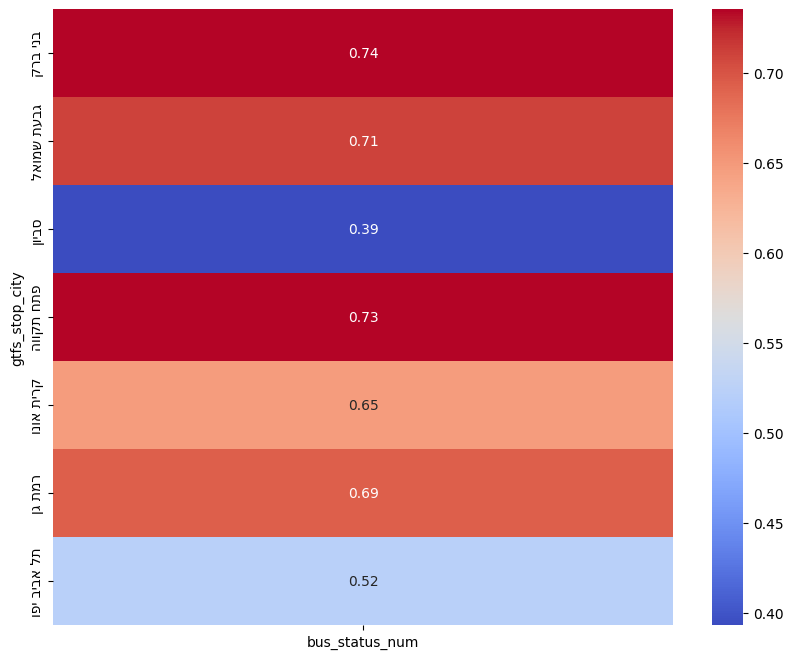

In [41]:
plot_city_heatmap(results)

# Applying Analysis to the Entire Dataset

In this section, we will apply the analysis we have developed to the entire dataset. Given the large size of the data (approximately 800GB), we will process the data in batches. This approach allows us to efficiently handle the data without overloading the memory.

When splitting into batches we can go in few different approaches:
1. Based on batch size limit - in this approach we only care about the size of the batch without any regard to its content.
2. Based on journey_ref - in this approach we will process each journey on its own. The main downside is the amount of batches - millions. which might lead to excessive overhead.
3. based on line_ref - in this approach we will process all journeys of a certain line in each batch. This could be helpful for training a model later in the notebook.
4. based on route_id - similar to the previous approach. could be better for a model training because its more unique.

## Splitting based on batch size

When first starting this part, the approach taken for splitting into batches was the first - based on batch size. 

After many hours of trial and error, many hours of data processing and many many hours of debugging - A conclusion was reached that a different approach was needed and this part must be ditched.

This code is still crucial for the project, so although it won't be used, it will not be deleted.

It should be noted that the code itself works, but every refinement needed in the created batches resulted in a very long wait time for the processing.



The steps we will follow are:

1. **Batch Creation**: We will create data batches, ensuring that each batch does not exceed a specified size limit. To maintain data integrity, we will ensure that all related lines (i.e., lines with the same 'siri_journey_ref') are included in the same batch.

2. **Batch Analysis**: We will apply our analysis to each batch individually. This includes any data cleaning, transformation, and statistical analysis we have previously defined.

3. **Results Aggregation**: After analyzing each batch, we will aggregate the results. This could involve combining the results into a single data structure, or it could involve saving the results of each batch's analysis to disk.

By processing the data in batches, we can scale our analysis to handle large datasets that would not otherwise fit into memory. Let's get started!


### Batch Creation Function

In this cell, we define a function `create_batch_df` to create data batches from the large dataset. The function takes the following parameters:

- `csv_dir`: The directory where the CSV files are stored.
- `batch_size_gb`: The maximum size of each batch in gigabytes.
- `last_journey_refs`: A set of 'siri_journey_ref' values that were included in the last batch and should be excluded from the current batch.
- `start_file`: The file to start reading from. If not specified, reading starts from the first file in the directory.
- `start_pos`: The position in the start file to start reading from.

The function works as follows:

1. It initializes an empty DataFrame for the batch and a set to keep track of the 'siri_journey_ref' values in the current batch.

2. It iterates over each file in the directory, starting from the `start_file` if specified.

3. For each file, it creates an iterator for the chunks in the file and reads the first chunk.

4. If there are any `last_journey_refs`, it excludes them from the chunk.

5. It then enters a loop where it adds the chunk to the batch if it doesn't exceed the `batch_size_gb`. If the batch size is exceeded, it adds only the rows with the same 'siri_journey_ref' as in the current batch.

6. The function returns the batch DataFrame, the set of 'siri_journey_ref' values in the current batch, the next chunk, the iterator for the next chunks, the next file, and the index of the next file.

By using this function, we can create manageable batches from the large dataset while ensuring that all related lines are included in the same batch.


In [19]:
def create_batch_df(parquet_dir, batch_size_gb, last_batch_journey_refs=None, start_file=None, start_pos=0):
    # Convert batch size from GB to bytes
    batch_size_bytes = batch_size_gb * 1024 * 1024 * 1024

    # Get a list of all output Parquet files
    parquet_files = glob.glob(f'{parquet_dir}/output_*.parquet')
    parquet_files.sort(key=extract_number)

    # If a start file is specified, start from this file
    if start_file is not None:
        parquet_files = parquet_files[parquet_files.index(start_file):]

    # Initialize an empty DataFrame for the batch
    batch_df = pd.DataFrame()

    # Initialize a set to keep track of the 'siri_journey_ref' values in the current batch
    current_journey_refs = set()

    for file in parquet_files:
        # Create an iterator for the chunks in the Parquet file
        parquet_file = pq.ParquetFile(file)
        chunk_iter = parquet_file.iter_batches(batch_size=100000)  # Adjust batch size as needed

        # Read the first chunk and convert it to a DataFrame
        chunk = pd.DataFrame(next(chunk_iter).to_pandas())

        # If there are any last journey refs, exclude them from the chunk
        if last_batch_journey_refs is not None:
            chunk = chunk[~chunk['siri_journey_ref'].isin(last_batch_journey_refs)]
        while True:
            # Add the chunk to the batch if it doesn't exceed the batch size
            if (batch_df.memory_usage(index=True, deep=True).sum() + chunk.memory_usage(index=True, deep=True).sum()) <= batch_size_bytes:
                batch_df = pd.concat([batch_df, chunk])
                current_journey_refs.update(chunk['siri_journey_ref'].unique())

            else:
                # If the batch size is exceeded, add only the rows with the same 'siri_journey_ref' as in the current batch
                current_journey_refs_in_chunk = chunk['siri_journey_ref'].isin(current_journey_refs)
                if current_journey_refs_in_chunk.any():
                    batch_df = pd.concat([batch_df, chunk[current_journey_refs_in_chunk]])
                    chunk = chunk[~current_journey_refs_in_chunk]

                # Return the current DataFrame and the set of 'siri_journey_ref' values
                return batch_df, current_journey_refs, chunk, chunk_iter, file, parquet_files.index(file)

            # Try to read the next chunk
            try:
                chunk = pd.DataFrame(next(chunk_iter).to_pandas())
            except StopIteration:
                break

    # If all files have been processed, return the current DataFrame and the set of 'siri_journey_ref' values
    return batch_df, current_journey_refs, None, None, None, None

def process_batch_df(batch_df):
    # Process the DataFrame
    df_bus_journey_stops, df_locations = process_dataframe(batch_df)

    print(f'Processed {len(df_bus_journey_stops)} bus journey stops and {len(df_locations)} locations.')
    # Process the locations
    df_locations = process_locations(df_locations)

    # Calculate the arrival times
    results = calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=30)

    print(f'Calculated arrival times for {len(results)} stops.')
    # Calculate the bus stats and update the DataFrame
    results = classify_buses(results, threshold=3)

    # Process the results
    results = time_features_extraction(results)

    return results

def save_processed_batch(batch_df):
    batch_num = uuid.uuid4()
    output_file = f'{DATA_FOLDER}/processed_batches/processed_batch_{batch_num}.parquet'
    print(f'Saving processed batch to {output_file}')
    batch_df.to_parquet(output_file, index=False, engine='fastparquet')    

def process_batches_parallel(batch_dfs):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_batch_df, batch_dfs))
    return results

In [20]:
def process_parquet_files(parquet_dir, batch_size_gb, num_batches):
    last_batch_journey_refs = None
    start_file = None
    start_pos = 0

    while True:
        batches = []
        for _ in range(num_batches):
            batch_df, last_batch_journey_refs, remaining_chunk, chunk_iter, start_file, start_pos = create_batch_df(parquet_dir, batch_size_gb, last_batch_journey_refs, start_file, start_pos)
            batches.append(batch_df)

            # If there are no more files to process, break the loop
            if start_file is None:
                break

        if not batches:
            break

        processes_batches =  process_batches_parallel(batches)

        for batch in processes_batches:
            save_processed_batch(batch)

        batches.clear()

    return results

In [18]:
batch_df, _, _, _, _, _ = create_batch_df(f'{DATA_FOLDER}/concatenated_data_parquet', 0.2)

In [24]:
process_parquet_files(f'{DATA_FOLDER}/concatenated_data_parquet', 0.4, 3)

In [22]:
# Specify the directory where your Parquet files are located
parquet_dir = f'{DATA_FOLDER}/concatenated_data_parquet'

# Create a batch of 1GB
batch_df, current_journey_refs, chunk, chunk_iter, file, file_index = create_batch_df(parquet_dir, batch_size_gb=0.2)

print(f'Batch DataFrame shape: {batch_df.shape}')

print(f'Batch size in GB: {batch_df.memory_usage(index=True, deep=True).sum() / 1024**3}')


In [ ]:
import cProfile

def profile_process_batch_df():

    # Use cProfile to profile the function
    profiler = cProfile.Profile()
    profiler.enable()

    # Call the function you want to profile
    process_batch_df(batch_df)

    # Disable the profiler after your function call
    profiler.disable()

    # Print the stats
    profiler.print_stats()

# Call the profiling function
profile_process_batch_df()

## Splitting based on route_id


In [21]:
# Function to establish a connection to the PostgreSQL database
def connect_to_db():
    # Replace the following with your database connection details
    user = 'postgres'
    password = 'postgres'
    host = 'localhost'
    port = '5433'
    db = 'siri_2023'
    return create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}')

def process_chunk(chunk, engine, file_name):
    chunk.to_sql('raw_data', engine, if_exists='append', index=False)
    print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} - Saved a chunk of {file_name} to the database.')

def process_file(file, engine):
    parquet_file = pq.ParquetFile(file)
    chunk_iter = parquet_file.iter_batches(batch_size=1000000)  # Adjust batch size as needed
    with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
        futures = []
        for batch in chunk_iter:
            chunk = pd.DataFrame(batch.to_pandas())
            # Submit each chunk to be processed by one of the workers
            futures.append(executor.submit(process_chunk, chunk, engine, os.path.basename(file)))
        concurrent.futures.wait(futures)

def save_to_db(parquet_dir, engine):
    parquet_files = glob.glob(f'{parquet_dir}/output_*.parquet')
    parquet_files.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit each file to be processed in parallel
        futures = [executor.submit(process_file, file, engine) for file in parquet_files]
        concurrent.futures.wait(futures)



# Connect to the database
engine = connect_to_db()
# save_to_db(f'{DATA_FOLDER}/concatenated_data_parquet', engine)


### Processing Strategy

After deciding to load all data into PostgreSQL, the next step is processing it.

Processing the data still needs to be done in batches. We aim to choose a batching strategy that minimizes processing time. Because using PostgreSQL eliminates many of the complications we encountered earlier with file-based methods, we now have more flexibility in choosing processing strategies. This increased flexibility will not affect the later stages of model training.

When choosing the group, we must choose a group that include an entire journey from start to end.
For example - A group made from the `gtfs_route_mkt` is a good group because each journey has exactly one `gtfs_route_mkt`, On the other end, a group made from `siri_stop_code` is not a good group because each journey has many bus stops.

In [22]:
def create_sql_query(table_name, group_column, value, start_date=None, end_date=None):
    sql_query = f"SELECT * FROM {table_name} WHERE {group_column} = '{value}' AND gtfs_arrival_time IS NOT NULL"
    if start_date is not None and end_date is not None:
        sql_query += f" AND recorded_at_time BETWEEN '{start_date}' AND '{end_date}'"
    elif start_date is not None:
        sql_query += f" AND recorded_at_time >= '{start_date}'"
    elif end_date is not None:
        sql_query += f" AND recorded_at_time <= '{end_date}'"

    return sql_query

def process_single_value(args):
    engine, table_name, group_column, start_date, end_date, value, enable_logging, total_values, index = args
    def log(message):
        if enable_logging:
            print(message)
    
    fetch_start_time = time.time()
    sql_query = create_sql_query(table_name, group_column, value, start_date, end_date)
    df = pd.read_sql(sql_query, engine, parse_dates=['recorded_at_time', 'siri_scheduled_start_time', 'gtfs_start_time', 'gtfs_end_time', 'gtfs_arrival_time', 'gtfs_departure_time'])
    df.drop(columns=['original_file'], inplace=True)
        
    fetch_end_time = time.time()
    log(f"Data for '{value}' in '{group_column}' fetched in {fetch_end_time - fetch_start_time:.2f} seconds.")
    
    group_start_time = time.time()
    
    # Process the data (assuming process_batch_df is a function you've defined to process your data)
    results = process_batch_df(df)
    
    # Save results in db
    results.to_sql('processed_data', engine, if_exists='append', index=False)
    
    group_end_time = time.time()
    log(f" [{index+1}/{total_values}] Processed group '{value}' in '{group_column}' in {group_end_time - group_start_time:.2f} seconds.")

def create_distinct_query(table_name, group_column, limit=None, offset=None):
        distinct_query = f"""
                            SELECT DISTINCT {group_column} 
                            FROM {table_name} 
                            WHERE {group_column} IS NOT NULL 
                            AND gtfs_arrival_time IS NOT NULL 
                            AND {group_column} NOT IN (SELECT DISTINCT {group_column} FROM processed_data)
                            """
        if limit is not None:
            distinct_query += f" LIMIT {limit}"
        if offset is not None:
            distinct_query += f" OFFSET {offset}"
        return distinct_query

def process_data_grouped_by_column(engine, table_name, group_column, start_date=None, end_date=None, limit=None, offset=None, enable_logging=False):
    start_time = time.time()
    if enable_logging:
        print(f"Starting processing for table '{table_name}' grouped by '{group_column}'")
    
    distinct_query = create_distinct_query(table_name, group_column, limit, offset)
    distinct_values_df = pd.read_sql(distinct_query, engine)
    total_values = len(distinct_values_df)
    if enable_logging:
        print(f"Distinct query executed and fetched {total_values} distinct values.")
    
    if limit is not None:
        distinct_values_df = distinct_values_df.head(limit)     
    
    args = [(engine, table_name, group_column, start_date, end_date, value, enable_logging, total_values, index) for index, value in enumerate(distinct_values_df[group_column])]
    
    # Use ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=None) as executor:
        futures = [executor.submit(process_single_value, arg) for arg in args]
        for future in concurrent.futures.as_completed(futures):
            future.result()  # You can handle exceptions here if needed
    
    end_time = time.time()
    if enable_logging:
        print(f"Total processing time for table '{table_name}' grouped by '{group_column}': {end_time - start_time:.2f} seconds.")

In [ ]:
process_data_grouped_by_column(engine, 'raw_data', 'gtfs_route_mkt',start_date=START_DATE, end_date=END_DATE, enable_logging=True)
# process_data_grouped_by_column(engine, 'raw_data', 'siri_journey_ref',start_date=START_DATE, end_date=END_DATE, limit=16, offset=1500, enable_logging=True)
# process_data_grouped_by_column(engine, 'raw_data', 'siri_vehicle_ref',start_date=START_DATE, end_date=END_DATE, limit=16, offset=150 enable_logging=True)
# process_data_grouped_by_column(engine, 'raw_data', 'siri_line_ref',start_date=START_DATE, end_date=END_DATE, limit=16, offset=55, enable_logging=True)

### Processing the data
After some tests with the above code, the chosen strategy is batching by gtfs_route_mkt.

In [ ]:
process_data_grouped_by_column(engine, 'raw_data', 'gtfs_route_mkt',start_date=START_DATE, end_date=END_DATE, enable_logging=True)

# Model Training 

In [33]:
df = pd.read_sql('SELECT * FROM processed_data WHERE gtfs_route_mkt = \'14068\'', engine)


In [45]:
label_encoder = LabelEncoder()


print("Starting data preprocessing...")
df['arrival_time_diff'] = df['arrival_time_diff'] / 1e9
df['city_encoded'] = label_encoder.fit_transform(df['gtfs_stop_city'])
df['vehicle_encoded'] = label_encoder.fit_transform(df['siri_vehicle_ref'])
df['line_encoded'] = label_encoder.fit_transform(df['siri_line_ref'])
df['stop_code_encoded'] = label_encoder.fit_transform(df['siri_stop_code'])
df['siri_stop_order'] = df['siri_stop_order'].astype(int)
print("Data preprocessing completed.")

Starting data preprocessing...
Data preprocessing completed.


In [30]:
from sklearn.ensemble import RandomForestRegressor



# Select features and target
print("Selecting features and target...")
features = df[['siri_stop_order', 'distance_from_stop', 'stop_code_encoded', 'line_encoded',
               'vehicle_encoded', 
               'recorded_at_time__hour', 
               'recorded_at_time__day_of_week',
               'recorded_at_time__minute',
               'recorded_at_time__day_of_month',
               'city_encoded'
]]  # Example features
target = df['arrival_time_diff']
print("Features and target selected.")

# Split the data into train and test sets
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print("Data split completed.")

# Initialize a regression model (Random Forest in this case)
print("Initializing the model...")
model = RandomForestRegressor(n_estimators=100, random_state=42)
print("Model initialized.")

# Train the model
print("Training the model...")
model.fit(X_train, y_train)
print("Model trained.")

# Make predictions on the test set
print("Making predictions...")
y_pred = model.predict(X_test)
print("Predictions made.")

# Evaluate the model
print("Evaluating the model...")
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print("Model evaluation completed.")

Selecting features and target...
Features and target selected.
Splitting data into train and test sets...
Data split completed.
Initializing the model...
Model initialized.
Training the model...
Model trained.
Making predictions...
Predictions made.
Evaluating the model...
Mean Absolute Error: 972.3563953973546
Root Mean Squared Error: 281027.96249086986
Model evaluation completed.


In [56]:
from statsmodels.tsa.stattools import adfuller

df.index = df['recorded_at_time']

# Select features and target
print("Selecting features and target...")
features = df[['siri_stop_order', 'distance_from_stop', 'stop_code_encoded', 'line_encoded',
               'vehicle_encoded',
               'city_encoded'
]]  # Example features
target = df['arrival_time_diff']
print("Features and target selected.")


# Split the data into train and test sets
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print("Data split completed.")


Selecting features and target...
Features and target selected.
Splitting data into train and test sets...
Data split completed.


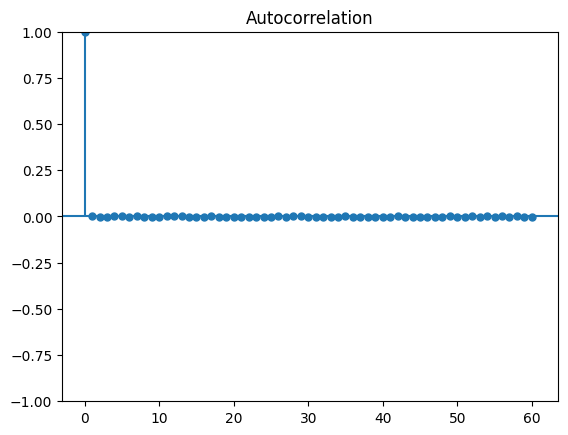

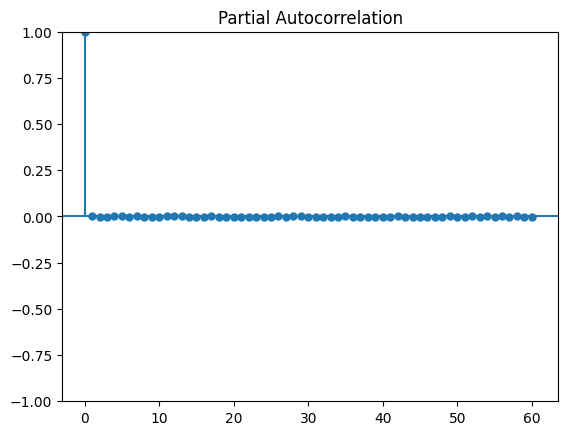

In [32]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y_train)
plot_pacf(y_train)
plt.show()

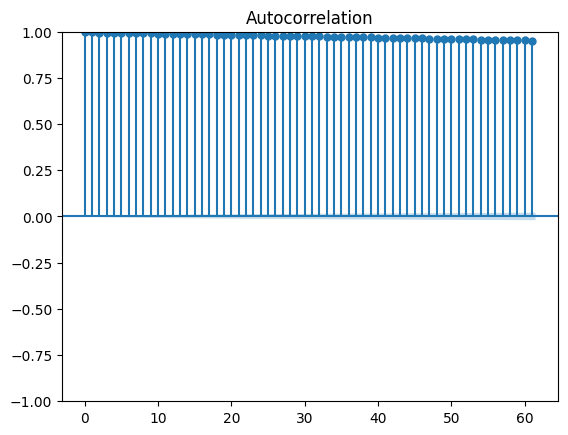

In [34]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['arrival_time_diff'])
plt.show()

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

print("Initializing the model...")
# Fit SARIMAX model
model = SARIMAX(y_train,
                 exog=X_train,
                 order=(1,0,1),  # specify ARIMA orders
                 seasonal_order=(1,0,0,24),  # specify seasonal orders
                 enforce_stationarity=False,
                 enforce_invertibility=False)
print("Model initialized.")

# Train the model
print("Training the model...")
model_fit = model.fit()
print("Model trained.")

# # Make predictions on the test set
# print("Making predictions...")
# predictions = results.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
# print("Predictions made.")

# # Evaluate the model
# print("Evaluating the model...")
# mae = mean_absolute_error(y_test, y_pred) / 1e9
# rmse = np.sqrt(mean_squared_error(y_test, y_pred)) / 1e9
# print(f'Mean Absolute Error: {mae} seconds')
# print(f'Root Mean Squared Error: {rmse} seconds')
# print("Model evaluation completed.")

Initializing the model...


c:\users\yoave\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\yoave\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\yoave\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\yoave\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monoto

Model initialized.
Training the model...


c:\users\yoave\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MemoryError: Unable to allocate 4.01 GiB for an array with shape (25, 25, 861729) and data type float64

In [55]:
print(type(X_test.index[0]))
print(X_test.index[0] in model_fit.data.orig_endog.index)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
False


In [54]:
# Make predictions on the test set
print("Making predictions...")
y_pred = model_fit.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
print("Predictions made.")

# Calculate errors
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Convert errors from nanoseconds to seconds
mae = mae / 1e9
rmse = rmse / 1e9

print(f'Mean Absolute Error: {mae} seconds')
print(f'Root Mean Squared Error: {rmse} seconds')

Making predictions...


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
# Evaluate the model
print("Evaluating the model...")
mae = mean_absolute_error(y_test, y_pred) / 1e9
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) / 1e9
print(f'Mean Absolute Error: {mae} seconds')
print(f'Root Mean Squared Error: {rmse} seconds')
print("Model evaluation completed.")

## Preprocessing


In [60]:
df['arrival_time_diff']

recorded_at_time
2023-01-02 06:06:55+00:00   -2.863613e-07
2023-01-02 06:10:20+00:00   -8.687011e-09
2023-01-02 06:06:55+00:00   -3.796633e-07
2023-01-02 06:13:39+00:00   -9.744767e-09
2023-01-02 06:14:39+00:00   -1.436143e-08
                                 ...     
2023-03-22 03:46:07+00:00   -4.794571e-07
2023-03-22 03:47:04+00:00   -4.196343e-07
2023-03-22 03:47:47+00:00   -4.335177e-07
2023-03-22 03:48:53+00:00   -4.176719e-07
2023-03-22 03:50:06+00:00   -4.497326e-07
Name: arrival_time_diff, Length: 1077162, dtype: float64

In [23]:
bus_data = batch.copy()
label_encoder = LabelEncoder()
bus_data['siri_journey_ref'] = label_encoder.fit_transform(bus_data['siri_journey_ref'])
# Dropping string columns
bus_data.drop(columns=['gtfs_route_short_name', 'gtfs_journey_ref', 'gtfs_arrival_time'], inplace=True) 
# Dropping null data
bus_data.dropna(inplace=True)
# formatting time diff to sec from TimeDelta
bus_data['arrival_time_diff'] = bus_data['arrival_time_diff'].dt.total_seconds()

bus_data['city_encoded'] = label_encoder.fit_transform(bus_data['gtfs_stop_city'])

bus_data = pd.get_dummies(bus_data, columns=['bus_status'])
bus_data.drop(columns=['bus_status_num'], inplace=True)

time_columns = [col for col in bus_data.columns if col.endswith('_time')]

for col in time_columns:
    # Convert the column to datetime
    bus_data[col] = pd.to_datetime(bus_data[col])
    
    # Create new columns for month, day of month, hour and minute
    bus_data[col + '__month'] = bus_data[col].dt.month
    bus_data[col + '__day'] = bus_data[col].dt.day
    bus_data[col + '__day_of_week'] = bus_data[col].dt.dayofweek
    bus_data[col + '__hour'] = bus_data[col].dt.hour
    bus_data[col + '__minute'] = bus_data[col].dt.minute

bus_data.drop(columns=time_columns, inplace=True)

id_features = ['id', 'siri_journey_ref', 'siri_vehicle_ref', 'siri_stop_code', 'siri_operator_ref', 'siri_line_ref']

other_features = ['gtfs_stop_sequence', 'siri_stop_order', 'gtfs_route_direction',
                   'closet_location_speed', 'closest_location_bearing', 'distance_from_stop',
                     'moving_towards_stop', 'city_encoded']
time_features = ['gtfs_start_time__day_of_week', 'gtfs_start_time__hour',
       'gtfs_end_time__day_of_week', 'gtfs_end_time__hour',
       'recorded_at_time__day_of_week', 'recorded_at_time__hour',
       'recorded_at_time__minute', 'recorded_at_time__day_of_month',
       'recorded_at_time__month', 'scheduled_arrival_time__month', 'scheduled_arrival_time__day',
       'scheduled_arrival_time__day_of_week', 'scheduled_arrival_time__hour',
       'scheduled_arrival_time__minute']

target_variables = ['bus_status_Early', 'bus_status_Late', 'bus_status_On Time', 'arrival_time_diff']
target_variables_time = ['estimated_arrival_time__month',
       'estimated_arrival_time__day', 'estimated_arrival_time__day_of_week',
       'estimated_arrival_time__hour', 'estimated_arrival_time__minute']

features = id_features + other_features + time_features 
target = target_variables + target_variables_time


NameError: name 'batch' is not defined

In [31]:
bus_data[features]

,id,siri_journey_ref,siri_vehicle_ref,siri_stop_code,siri_operator_ref,siri_line_ref,gtfs_stop_sequence,siri_stop_order,gtfs_route_direction,closet_location_speed,...,recorded_at_time__day_of_week,recorded_at_time__hour,recorded_at_time__minute,recorded_at_time__day_of_month,recorded_at_time__month,scheduled_arrival_time__month,scheduled_arrival_time__day,scheduled_arrival_time__day_of_week,scheduled_arrival_time__hour,scheduled_arrival_time__minute
0,1473611409,0,7728469,2524,3,12390,1,1,2,2.474103e+06,...,3,12,26,5,1,1,5,3,12,3
17,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
18,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
19,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
20,1473609384,0,7317852,6071,50,15138,1,1,1,1.286680e+06,...,3,12,0,5,1,1,5,3,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429073,1473908971,2326,7728669,5985,3,11108,33,33,2,6.744721e+01,...,3,12,55,5,1,1,5,3,12,41
429074,1473914652,2326,7728669,2811,3,11108,34,34,2,1.018009e+02,...,3,12,56,5,1,1,5,3,12,42
429075,1473920304,2326,7728669,109,3,11108,35,35,2,6.962211e+01,...,3,12,57,5,1,1,5,3,12,43
429076,1473925951,2326,7728669,112,3,11108,36,36,2,6.842899e+01,...,3,12,58,5,1,1,5,3,12,43


In [29]:
import category_encoders as ce

X = bus_data[features]
y = bus_data[target]

# Binary encode categorical features
encoder = ce.BinaryEncoder(cols=id_features)
X_encoded = encoder.fit_transform(X)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)



# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('after scaler')

# Define RNN model
model = Sequential([
    LSTM(units=64, input_shape=(X_train_scaled.shape[1], 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(target), activation='linear')
])

print('after model')

# Compile model
model.compile(optimizer='adam', loss='mse')

print('after compile')

# Reshape input data for LSTM layer
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Train model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

print('after fit')

# Evaluate model
loss = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)

NameError: name 'bus_data' is not defined

In [174]:
label_encoder = LabelEncoder()
batch['siri_journey_ref'] = label_encoder.fit_transform(batch['siri_journey_ref'])
batch.drop(columns=['gtfs_stop_city', 'gtfs_route_short_name', 'gtfs_journey_ref', 'gtfs_arrival_time'], inplace=True)
batch.dropna(subset=['scheduled_arrival_time'], inplace=True)
batch['arrival_time_diff'] = batch['arrival_time_diff'].dt.total_seconds()


time_columns = [col for col in batch.columns if col.endswith('_time')]

for col in time_columns:
    # Convert the column to datetime
    batch[col] = pd.to_datetime(batch[col])
    
    # Create new columns for month, day of month, hour and minute
    batch[col + '_month'] = batch[col].dt.month
    batch[col + '_day'] = batch[col].dt.day
    batch[col + '_hour'] = batch[col].dt.hour
    batch[col + '_minute'] = batch[col].dt.minute

batch.drop(columns=time_columns, inplace=True)



In [175]:
batch.dropna(inplace=True)

target_variables = ['estimated_arrival_time_month', 'estimated_arrival_time_day', 'estimated_arrival_time_hour', 'estimated_arrival_time_minute', 'arrival_time_diff', 'bus_status_Early', 'bus_status_Late',
       'bus_status_Missing', 'bus_status_On Time', 'bus_status_num']

# Define features (X) and target variable (y)
X = batch.drop(columns=target_variables, axis=1)  # Features
y = batch[target_variables]  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Print the shapes of the train and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (447810, 34) (447810, 10)
Testing set shape: (298540, 34) (298540, 10)


In [1]:
batch.head()

NameError: name 'batch' is not defined

In [180]:
X_train.columns
# print(X_test.isnull().sum())



Index(['id', 'siri_journey_ref', 'siri_vehicle_ref', 'siri_stop_code',
       'siri_stop_order', 'siri_operator_ref', 'siri_line_ref',
       'gtfs_stop_code', 'gtfs_stop_lat', 'gtfs_stop_lon',
       'gtfs_stop_sequence', 'gtfs_route_direction', 'gtfs_route_mkt',
       'closest_location', 'closest_location_lat', 'closest_location_lon',
       'closet_location_speed', 'closest_location_bearing',
       'distance_from_stop', 'moving_towards_stop',
       'gtfs_start_time__day_of_week', 'gtfs_start_time__hour',
       'gtfs_end_time__day_of_week', 'gtfs_end_time__hour',
       'recorded_at_time__day_of_week', 'recorded_at_time__hour',
       'recorded_at_time__minute', 'day_of_month', 'month', 'city_encoded',
       'scheduled_arrival_time_month', 'scheduled_arrival_time_day',
       'scheduled_arrival_time_hour', 'scheduled_arrival_time_minute'],
      dtype='object')

In [176]:
# Initialize the scaler
scaler = StandardScaler()


# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Access the coefficients of the linear regression model
coefficients = model.coef_
print(coefficients)
coefficients_flat = coefficients.flatten()

# Create a DataFrame to display the coefficients with their corresponding feature names
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients_flat})
print(feature_importance)

In [178]:
y_pred = model.predict(X_test_scaled)

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)



In [35]:
import pandas as pd
from sqlalchemy import create_engine

# Read the Parquet file
df = pd.read_parquet('2023_siri_data/concatenated_data_parquet/output_1_from_2023-01-01.00_at_0_to_2023-01-03.05_at_69983.parquet')

# Create the connection string
database_username = 'postgres'
database_password = 'postgres'
database_ip       = 'localhost'
database_name     = 'siri_2023'
database_connection = f'postgresql://{database_username}:{database_password}@{database_ip}/{database_name}'

# Create SQLAlchemy engine
engine = create_engine(database_connection)

# Insert the dataframe into the PostgreSQL table
df.to_sql('processed_data', engine, if_exists='append', index=False)

PendingRollbackError: Can't reconnect until invalid transaction is rolled back.  Please rollback() fully before proceeding (Background on this error at: https://sqlalche.me/e/20/8s2b)